# **Data Modelling and Evaluation**

## Objectives

* This notebook will address business requirtement 2: "Predicting if a cherry leaf is healthy or contains powdery mildew."

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* embeddings of image shapes

## Outputs

* plot of image distribution in train, validation, and test set
* image augmentation
* class indices to change prediction inference in labels
* machine learning model creation and training
* save the trained model
* learning curve plot for model performance
* model evaluation on pickle file
* prediction on the random image file

## Additional Comments

* This notebook develops the ML model and trains it with the train and validation image datasets. The test dataset will help to determine if business requirement 2 has been met.



---

## Import Libraries

In [ ]:
import os
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

## Set working directory

In [2]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
current_dir

'/Users/nathalievonheyl/Documents/ci-code_institute/PP5/pp5_mildew-detection'

## Set input directories

Set paths for train, validation and test sets

In [3]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, "train")
val_path = os.path.join(my_data_dir, "validation")
test_path = os.path.join(my_data_dir, "test")

## Set output directory

In [4]:
version = 'v1'
file_path = os.path.join("outputs", version)

if os.path.exists(file_path):
    print('Old version is already available create a new version.')
else:
    os.makedirs(file_path)

Old version is already available create a new version.


## Set Labels

In [5]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


## Set image shape

Import the saved image shape embedding

In [6]:
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Visualizing class distributions

**Function to count number of images in each directory**

Count the number of images in each of the folders ('train', 'validation', and 'test') and subfolders (labels). The counts will then be stored in a dictionary. This dictionary is then converted into a DataFrame which will be visualizing the label distribution in each directory as a bar plot. This helps to determine if there is an equal amount if images per label in each directory.

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




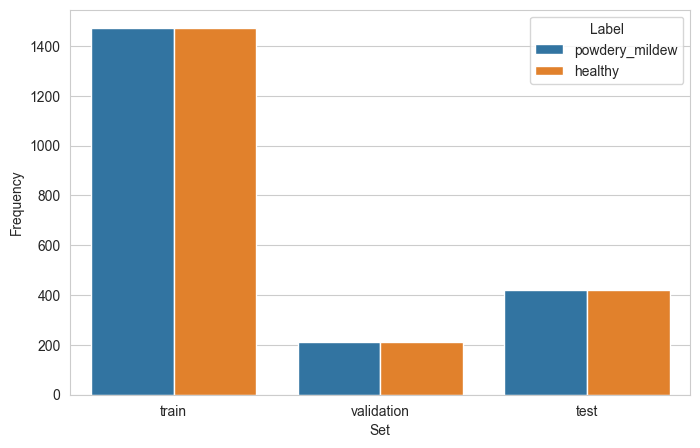

In [7]:
data = {'Set': [], 'Label': [], 'Frequency': []}

folders = ['train', 'validation', 'test']

for folder in folders:
    for label in labels:
        label_path = os.path.join(my_data_dir, folder, label)
        image_count = len(os.listdir(label_path))

        data['Set'].append(folder)
        data['Label'].append(label)
        data['Frequency'].append(image_count)

        print(
            f"* {folder} - {label}: {image_count} images")

df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')

plt.savefig(os.path.join(file_path, 'labels_distribution.png'), bbox_inches='tight', dpi=150)
plt.show()

The class labels are evenly distributed among the split sets. No futher action needed.

---

## Image data augmentation

Generate batches of image data with real-time data augmentation. This process is artificially creating more training images with a combination of multiple processes (e.g. random rotation, shifting width or height, shearing, zooming, flipping horizontally and vertically, optionally filling broken pixels with nearest pixel value, and standardizing the image pixels between 0 to 255 pixels).

In [8]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* Augment the train image dataset

In [9]:
batch_size = 20
train_set = augmented_image_data.flow_from_directory(train_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True
                                                    )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* Augment the validation image dataset

In [10]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* Augment the test image dataset

In [11]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented images

* Plot augmented images from the training dataset

(20, 256, 256, 3)


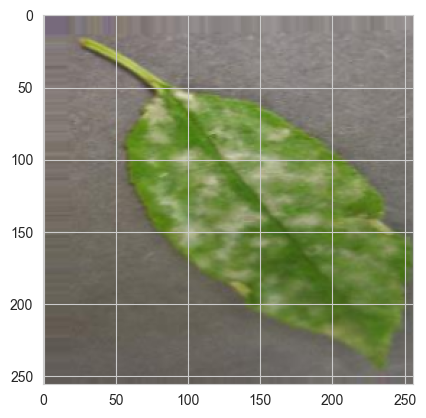

(20, 256, 256, 3)


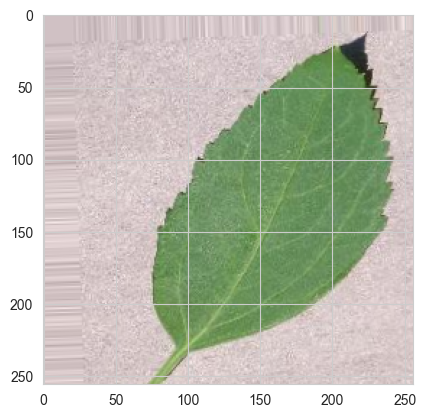

(20, 256, 256, 3)


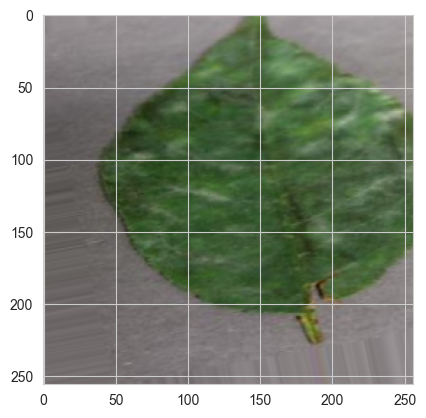

In [12]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

* Plot augmented images from the validation dataset

(20, 256, 256, 3)


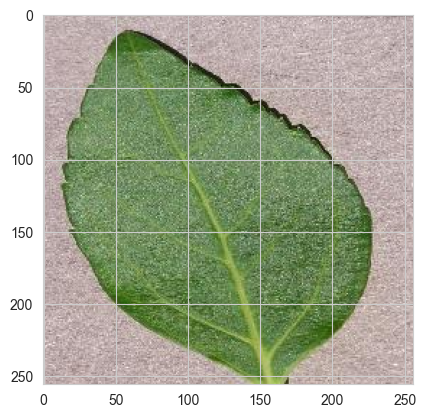

(20, 256, 256, 3)


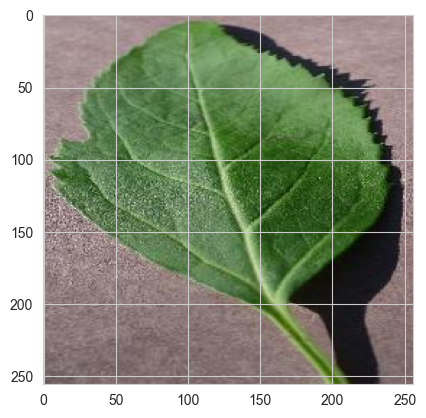

(20, 256, 256, 3)


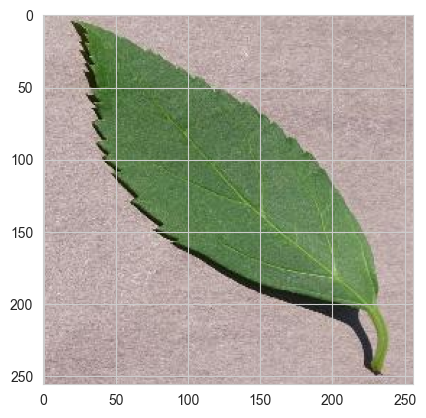

In [13]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

* Plot augmented images from the testing dataset

(20, 256, 256, 3)


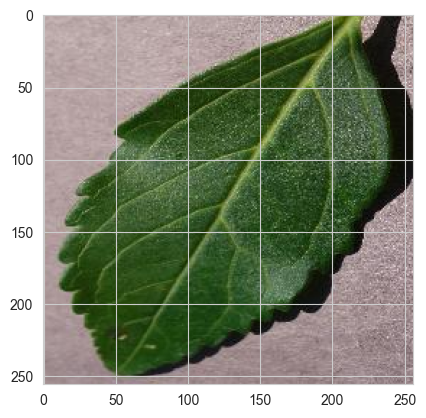

(20, 256, 256, 3)


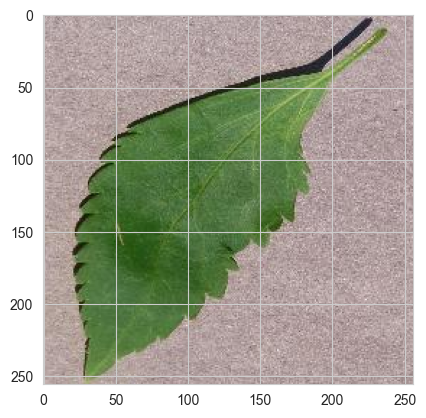

(20, 256, 256, 3)


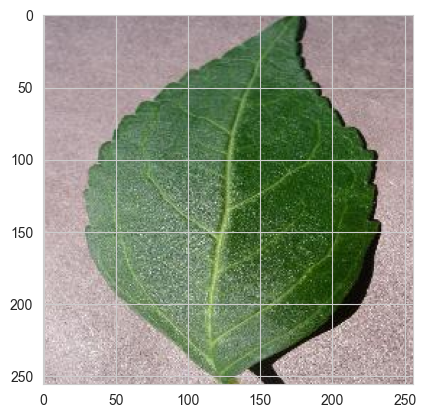

In [14]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [15]:
joblib.dump(value=train_set.class_indices, filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## ML Model Creation

### Create machine learning model

The following function has no inputs, because all settings are predefined within the function. The function contains three convolutional layers (`Conv2D`) to detect patterns in the images. `MaxPooling2D` to reduce image size. The `Flatten` layer is used to flatten the matrix into a vector (single list of all values) which is fed into a `Dense`. The `Dense` layer computes classification and passes the output.

`Dropout` is then applied to prevent overfitting by dropping a certain percentage of nodes.

The model's output could also be a matrix instead of a single binary value. Use `softmax` as activation function instead of `sigmoid`. To ensure compatibility, then choose loss function `categorical_crossentropy`.

The function returns a the cnn model.

In [17]:
def create_tf_model():
    """
    Function to create a CNN model for image classification
    
    Outputs a model with two categories
    """
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

### ML Model Summary

In [18]:
create_tf_model().summary()

/Users/nathalievonheyl/Documents/ci-code_institute/PP5/virtual_envs/mildew_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,506 (28.34 MB)

 Trainable params: 7,429,506 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

### Callbacks

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

**Note to self**

What about tensorflow.keras.callbacks module ModelCheckpoint to monitor accuracy and save best model?

## Fit CNN Model for model training

In [20]:
model = create_tf_model()
model.fit(train_set,
          epochs=20,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

/Users/nathalievonheyl/Documents/ci-code_institute/PP5/virtual_envs/mildew_venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 49s 328ms/step - accuracy: 0.7638 - loss: 0.4532 - val_accuracy: 0.9976 - val_loss: 0.0236
Epoch 2/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:08 470ms/step - accuracy: 1.0000 - loss: 0.0412

/Users/nathalievonheyl/Documents/ci-code_institute/PP5/virtual_envs/mildew_venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0.0412 - val_accuracy: 0.9976 - val_loss: 0.0231
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 51s 344ms/step - accuracy: 0.9727 - loss: 0.0758 - val_accuracy: 0.9976 - val_loss: 0.0201
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9976 - val_loss: 0.0177
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 58s 397ms/step - accuracy: 0.9851 - loss: 0.0444 - val_accuracy: 0.9833 - val_loss: 0.0523
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0.0426 - val_accuracy: 0.9833 - val_loss: 0.0546
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 52s 352ms/step - accuracy: 0.9879 - loss: 0.0354 - val_accuracy: 0.9952 - val_loss: 0.0078
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9952 - val_loss: 0.0069
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 54s 370ms/step - accuracy: 0.9914 - loss: 0.0269 - val_accurac

### Save Model

Save the fitted model for training. Use native keras format (.keras), which is recommended by keras documentation. This ensures that the model can be easily reloaded.

In [21]:
model.save('outputs/v1/mildew_detection_model.keras')

---

## ML model Performance

### Learning Curve

Goal of the following steps: 

Review the learning curve of the model created, plot model performance, evaluate model performance on test set, and save its performance (pickle file). Finally, predict model output on a random image file.

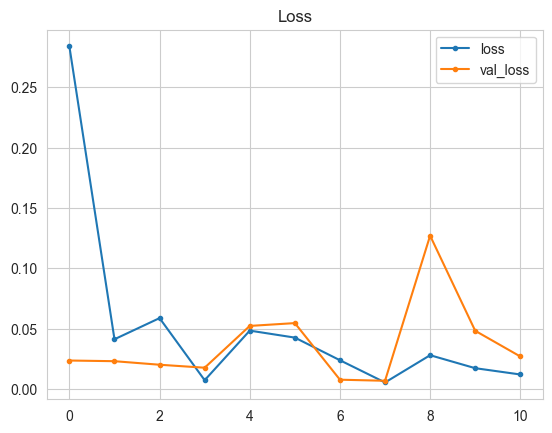

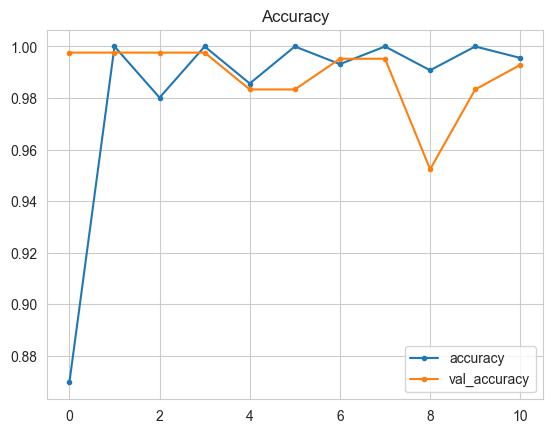

In [22]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=125)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=125)
plt.show()

This learning curve shows the loss and accuracy of the model on the train and validation dataset per epoch. It shows how the model behaves with the validation image data during training process.

In a normal model, both learning curves for train and validation dataset show a classic exponential improvement curve that is expected during successful training phase.

But here: Unlike the training curves, the validation accuracy and loss remain nearly flat throughout training. Validation accuracy stays consistently high (close to 1.0) from the beginning. Validation loss remains very low (close to 0) from the first epoch on. Also, there is a significant outlier at epoch 8, where validation loss spikes to approximately 0.125 and accuracy drops to around 0.95.

This pattern is neither clearly overfitting nor underfitting, but raises concerns what the outlier at epoch 8 could indicate.

The lack of a real learning curve on the validation set (since it's almost flat from the beginning) makes it difficult to confirm whether the model is really learning patterns or simply memorizing training data.

Before further concluding any adjustments to the model, the next step is to calculate the precise numeric value that represents an evaluation of loss and accuracy of the model's performance on test and validation set.

### Analysis training and validation behaviour of model

Before evaluating test set, the concerns about unusual validation learning curve have to be addressed and investigated.

In [ ]:
model = load_model('outputs/v1/mildew_detection_model.keras')

print("Evaluating validation set:")
val_loss, val_accuracy = model.evaluate(validation_set)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Evaluating validation set:
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9989 - loss: 0.0041 
Validation Loss: 0.0270
Validation Accuracy: 0.9929


After analyzing the numerical values of accuracy and loss of the validation set, the results are actually within the required criteria.

Proceed with evaluation of test set.

### Evaluation of Model on test dataset

Evaluate to check generalized loss and accuracy over test dataset.

In [28]:
model = load_model('outputs/v1/mildew_detection_model.keras')

In [29]:
evaluation = model.evaluate(test_set)

/Users/nathalievonheyl/Documents/ci-code_institute/PP5/virtual_envs/mildew_venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9959 - loss: 0.0194


Save evaluation result in .pkl file.

In [30]:
joblib.dump(value=evaluation, filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Evaluation of Model on predicting new data

**Load random image as PIL**

This code selects and loads a random image from the test image dataset.

* Randomly select an image file (`image_path`) from all images in `image_folder` (test_path/label)
* Generate full path to the selected file, making it accessible for potential further use
* Load the image, option to resize it according to `image_shape` variable and convert it to RGB
* Display randomly selected image along with info about shape and color mode

It helps to dynamically preview different test images from a category to prejudge if the model is predicting new data accurately.

Image shape: (256, 256), Image mode: RGB


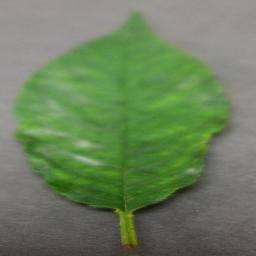

In [62]:
label = labels[0]

image_folder = os.path.join(test_path, label)
image_filename = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, image_filename)

pil_image = image.load_img(image_path, target_size=image_shape, color_mode='rgb')

print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

**Convert image to array and prepare for prediction**

In [63]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


**Predict class probabilities**

This code loads the test image from above, processes it, and uses the trained CNN model to predict its class.

With a sigmoid activation function, a threshold would be needed to determine the class. However, the created model uses softmax activation function with two nodes, which in theory is a multiclass approach. 

Softmax is a good choice here as an activation function because it can give two separate probability values for each of the two classes. The sum of both probabilities would always be 1, e.g., [0.2, 0.8] meaning class 1 is more likely compared to class 0.

Running the model on the loaded image gets an array of probabilities for both classes. Determine the index of the highest probability with `np.argmax(pred_proba)`. This index is then mapped to the corresponding class label using `target_map`. Display class label with descriptive title instead of a numeric binary value.

In [64]:
pred_proba = model.predict(my_image)[0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class_index = np.argmax(pred_proba)
pred_class = target_map[pred_class_index]
print(pred_proba[pred_class_index])
print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
0.9999349
powdery_mildew


---